In [1]:
using Flux, ParameterSchedulers, Optimisers, Statistics, CUDA 
using Base.Iterators: repeated, partition
using Printf, BSON, JLD2, LinearAlgebra
using ImageCore, Images
using MLDatasets: convert2image, FashionMNIST
using DataAugmentation, MLUtils
using Random: seed!

In [2]:
seed!(123)

Random.TaskLocalRNG()

In [ ]:
#Wczytanie danych
traintuple = FashionMNIST(:train)
testtuple = FashionMNIST(:test)

X_train_raw, y_train_raw = traintuple[:]
X_test_raw, y_test_raw = testtuple[:]

println("Dane FashionMNIST wczytane:")
println(" - Rozmiar X_train_raw: ", size(X_train_raw))
println(" - Rozmiar y_train_raw: ", size(y_train_raw))
println(" - Unikalne etykiety: ", unique(y_train_raw))

Dane FashionMNIST wczytane:
 - Rozmiar X_train_raw: (28, 28, 60000)
 - Rozmiar y_train_raw: (60000,)
 - Unikalne etykiety: [9, 0, 3, 2, 7, 5, 1, 6, 4, 8]


Etykieta dla obrazka 10: 5


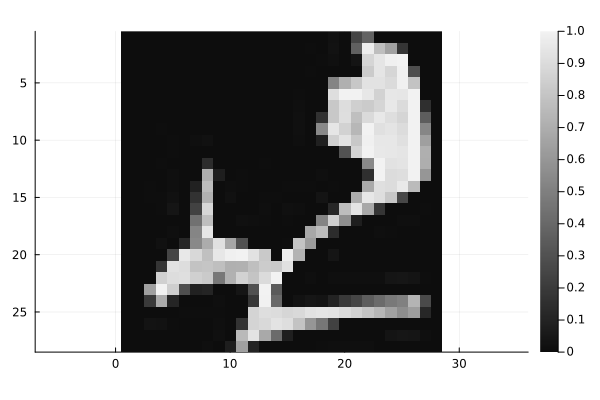

In [4]:
#Wizualizacja przykładowych danych (opcjonalnie, ale zalecane)
using Plots
idx_to_show = 10
println("Etykieta dla obrazka $idx_to_show: $(y_train_raw[idx_to_show])")
heatmap(X_train_raw[:,:,idx_to_show], aspect_ratio=:equal, color=:grays, yflip=true)

In [5]:
#Wstępne Przetwarzanie Danych (Preprocessing)
function preprocess_features(data)
    return Float32.(reshape(data, 28, 28, 1, size(data, ndims(data)))) ./ 255.0f0
end

X_train_processed = preprocess_features(X_train_raw)
X_test_processed = preprocess_features(X_test_raw)

println("Rozmiar X_train po preprocessingu: ", size(X_train_processed))
println("Rozmiar X_test po preprocessingu: ", size(X_test_processed))

Rozmiar X_train po preprocessingu: (28, 28, 1, 60000)
Rozmiar X_test po preprocessingu: (28, 28, 1, 10000)


In [6]:
#Kodowanie Etykiet (One-Hot Encoding)
y_train_onehot = Flux.onehotbatch(y_train_raw, 0:9)
y_test_onehot = Flux.onehotbatch(y_test_raw, 0:9)

println("Rozmiar y_train_onehot: ", size(y_train_onehot))
println("Rozmiar y_test_onehot: ", size(y_test_onehot))

Rozmiar y_train_onehot: (10, 60000)
Rozmiar y_test_onehot: (10, 10000)


In [7]:
# Przygotowanie DataLoaderów dla zbioru treningowego
batch_size = 128
train_loader = DataLoader((X_train_processed, y_train_onehot), batchsize=batch_size, shuffle=true)
test_loader = DataLoader((X_test_processed, y_test_onehot), batchsize=batch_size, shuffle=false)

# Sprawdzenie wymiarów batcha z loadera
first_batch_x, first_batch_y = first(train_loader)
println("Rozmiar X w pierwszym batchu: ", size(first_batch_x))
println("Rozmiar Y w pierwszym batchu: ", size(first_batch_y))

Rozmiar X w pierwszym batchu: (28, 28, 1, 128)
Rozmiar Y w pierwszym batchu: (10, 128)


In [24]:
#Tworzenie Modelu CNN
#Model 1 acc 90,46%
# function create_advanced_custom_cnn(inchannels=1, nclasses=10)
#     # Wejście 28x28x1
#     return Chain(
#         Conv((5,5), inchannels=>32, pad=(1,1), relu),
#         MaxPool((2,2)),                             
#         Dropout(0.2),
        
#         Conv((5,5), 32=>64,  pad=(1,1), relu),  
#         MaxPool((2,2)),                            
#         Dropout(0.2),

#         Conv((5,5), 64=>256, pad=(1,1), relu),     
#         MaxPool((2,2)),                          
#         Dropout(0.2),
        
#         Flux.flatten,                            
#         Dense(256 => 128, relu),               
#         Dropout(0.3),
#         Dense(128 => 64, relu),
#         Dense(64 => nclasses)
#     )
# end
function create_advanced_custom_cnn(inchannels=1, nclasses=10)
    return Chain(
    Conv((3,3), 1=>32, pad=Flux.SamePad()),
    Flux.relu,
    BatchNorm(32),

    Conv((3,3), 32=>32, pad=Flux.SamePad()),
    Flux.relu,
    BatchNorm(32),
    Dropout(0.25),

    Conv((3,3), 32=>64, pad=Flux.SamePad()),
    Flux.relu,
    MaxPool((2,2)),
    Dropout(0.25),

    Conv((3,3), 64=>128, pad=Flux.SamePad()),
    Flux.relu,
    BatchNorm(128),
    Dropout(0.25),

    Flux.flatten,        

    Dense(14*14*128, 512),
    Flux.relu,
    BatchNorm(512),
    Dropout(0.5),

    Dense(512, 128),
    Flux.relu,
    BatchNorm(128),
    Dropout(0.5),

    Dense(128, 10),
    Flux.softmax
    )
end


# Wybór modelu
model = create_advanced_custom_cnn()
println("Zdefiniowano model: Ulepszony Custom CNN")

Zdefiniowano model: Ulepszony Custom CNN


In [ ]:
model_cpu = create_advanced_custom_cnn()
println("Model został zdefiniowany na CPU.")

Model został zdefiniowany na CPU.


In [26]:
global device
if CUDA.functional()
    println("CUDA GPU jest dostępne. Używam GPU.")
    CUDA.allowscalar(false)
    device = gpu
    global model = model_cpu |> device
    println("Model został przeniesiony na GPU.")
else
    println("CUDA GPU niedostępne. Używam CPU.")
    device = cpu
    global model = model_cpu
end

CUDA GPU jest dostępne. Używam GPU.
Model został przeniesiony na GPU.


In [27]:
#Funkcja Straty, Optymalizator i Harmonogram Uczenia
loss_fn(y_pred, y_true) = Flux.logitcrossentropy(y_pred, y_true)

initial_lr = 1e-3
weight_decay_val = 1e-4
num_epochs = 150

# base_optimizer  = Optimisers.AdamW(initial_lr, (0.9, 0.999), weight_decay_val)
# total_iterations = num_epochs * length(train_loader)
# lr_scheduler = CosAnneal(λ0=initial_lr, λ1=initial_lr/100, period=total_iterations)

base_optimizer = Flux.Adam(initial_lr)
lr_scheduler = ParameterSchedulers.Stateful(Exp(start = base_optimizer.eta/10, decay = 0.1))

# opt = ParameterSchedulers.Scheduler(lr_scheduler, base_optimizer)

opt_state = Optimisers.setup(base_optimizer, model)

(layers = ((σ = (), weight = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;;; … ;;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0], Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;;; … ;;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), stride = ((), ()), pad = ((), (), (), ()), dilation = ((), ())

In [28]:
# Funkcja na dokładnośc oraz definicja zmiennych
function calculate_accuracy(y_pred_logits, y_true_onehot)
    pred_labels = Flux.onecold(y_pred_logits)
    true_labels = Flux.onecold(y_true_onehot)
    return mean(pred_labels .== true_labels)
end

calculate_accuracy (generic function with 1 method)

In [29]:
#Pętla Treningowa i Ewaluacja
@info "Rozpoczęcie treningu..."
best_val_accuracy = 0.0
best_model_path = "fashion_mnist_best_model.bson"
patience_counter = 0
patience_limit = 10
last_improvement = 0
iter_count = 0 

for epoch in 1:num_epochs
    Flux.trainmode!(model)
    epoch_train_loss = 0.0
    num_train_samples = 0

    # Pętla po batchach treningowych
    for (x_batch, y_batch) in train_loader
        x_batch_dev = x_batch |> device
        y_batch_dev = y_batch |> device

        # iter_count += 1
        # current_lr = lr_scheduler(iter_count)
        # Optimisers.adjust!(opt_state, current_lr)

        # Obliczanie gradientów
        loss, grads = Flux.withgradient(model) do m
            y_hat = m(x_batch_dev)
            current_loss = loss_fn(y_hat, y_batch_dev)
            current_loss
        end

        Optimisers.update!(opt_state, model, grads[1])

        epoch_train_loss += loss * size(x_batch, 4)
        num_train_samples += size(x_batch, 4)
    end

    avg_epoch_train_loss = epoch_train_loss / num_train_samples

    # Ewaluacja na zbiorze testowym
    Flux.testmode!(model)
    epoch_val_loss = 0.0
    epoch_val_acc = 0.0
    num_val_samples = 0

    for (x_batch_val, y_batch_val) in test_loader
        x_batch_val_dev = x_batch_val |> device
        y_batch_val_dev = y_batch_val |> device

        y_hat_val = model(x_batch_val_dev)
        epoch_val_loss += loss_fn(y_hat_val, y_batch_val_dev) * size(x_batch_val, 4)
        epoch_val_acc += calculate_accuracy(y_hat_val, y_batch_val_dev) * size(x_batch_val, 4)
        num_val_samples += size(x_batch_val, 4)
    end

    avg_epoch_val_loss = epoch_val_loss / num_val_samples
    avg_epoch_val_acc = epoch_val_acc / num_val_samples

    @printf "Epoch: %d/%d | Train Loss: %.4f | Val Loss: %.4f | Val Acc: %.4f%% \n" epoch num_epochs avg_epoch_train_loss avg_epoch_val_loss (avg_epoch_val_acc*100)

    # Zapis najlepszego modelu i Early Stopping
    if avg_epoch_val_acc > best_val_accuracy
        best_val_accuracy = avg_epoch_val_acc
        println("Nowa najlepsza dokładność walidacyjna: $(round(best_val_accuracy*100, digits=2))%. Zapisuję model do '$best_model_path'")
        model_to_save = model |> cpu
        @save best_model_path model_to_save
        patience_counter = 0
        last_improvement = epoch
    else
        patience_counter += 1
    end

    if patience_counter >= patience_limit
        println("Early stopping: Przekroczono limit cierpliwości ($patience_limit epok bez poprawy).")
        break
    end
    if epoch - last_improvement >= 5 
        η = ParameterSchedulers.next!(lr_scheduler) 
        if η ≥ 1e-10
            Optimisers.adjust(opt_state, eta = η)
            @warn(" -> Haven't improved in a while, dropping learning rate to $(η)!")
            last_improvement = epoch
        end
    end

    if best_val_accuracy > 0.95
        println("Osiągnięto docelową dokładność >95%!")
        break 
    end
end
@info "Zakończono trening."

[ Info: Rozpoczęcie treningu...


Epoch: 1/150 | Train Loss: 1.6448 | Val Loss: 1.5869 | Val Acc: 87.5400% 
Nowa najlepsza dokładność walidacyjna: 87.54%. Zapisuję model do 'fashion_mnist_best_model.bson'
Epoch: 2/150 | Train Loss: 1.5956 | Val Loss: 1.5753 | Val Acc: 88.5500% 
Nowa najlepsza dokładność walidacyjna: 88.55%. Zapisuję model do 'fashion_mnist_best_model.bson'
Epoch: 3/150 | Train Loss: 1.5733 | Val Loss: 1.5641 | Val Acc: 89.7600% 
Nowa najlepsza dokładność walidacyjna: 89.76%. Zapisuję model do 'fashion_mnist_best_model.bson'
Epoch: 4/150 | Train Loss: 1.5640 | Val Loss: 1.5590 | Val Acc: 90.2900% 
Nowa najlepsza dokładność walidacyjna: 90.29%. Zapisuję model do 'fashion_mnist_best_model.bson'
Epoch: 5/150 | Train Loss: 1.5577 | Val Loss: 1.5546 | Val Acc: 90.5900% 
Nowa najlepsza dokładność walidacyjna: 90.59%. Zapisuję model do 'fashion_mnist_best_model.bson'
Epoch: 6/150 | Train Loss: 1.5517 | Val Loss: 1.5642 | Val Acc: 89.5700% 
Epoch: 7/150 | Train Loss: 1.5492 | Val Loss: 1.5506 | Val Acc: 91.0100

┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.0001!
└ @ Main In[29]:80


Epoch: 31/150 | Train Loss: 1.5101 | Val Loss: 1.5305 | Val Acc: 93.0700% 
Epoch: 32/150 | Train Loss: 1.5097 | Val Loss: 1.5273 | Val Acc: 93.3000% 
Nowa najlepsza dokładność walidacyjna: 93.3%. Zapisuję model do 'fashion_mnist_best_model.bson'
Epoch: 33/150 | Train Loss: 1.5068 | Val Loss: 1.5283 | Val Acc: 93.2500% 
Epoch: 34/150 | Train Loss: 1.5071 | Val Loss: 1.5334 | Val Acc: 92.7400% 
Epoch: 35/150 | Train Loss: 1.5075 | Val Loss: 2.1705 | Val Acc: 28.3600% 
Epoch: 36/150 | Train Loss: 1.5308 | Val Loss: 1.5353 | Val Acc: 92.5600% 
Epoch: 37/150 | Train Loss: 1.5148 | Val Loss: 1.5341 | Val Acc: 92.7400% 


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 1.0e-5!
└ @ Main In[29]:80


Epoch: 38/150 | Train Loss: 1.5105 | Val Loss: 1.5383 | Val Acc: 92.2600% 
Epoch: 39/150 | Train Loss: 1.5066 | Val Loss: 1.5343 | Val Acc: 92.6600% 
Epoch: 40/150 | Train Loss: 1.5058 | Val Loss: 1.5346 | Val Acc: 92.6200% 
Epoch: 41/150 | Train Loss: 1.5050 | Val Loss: 1.5301 | Val Acc: 93.0300% 
Epoch: 42/150 | Train Loss: 1.5035 | Val Loss: 1.5287 | Val Acc: 93.1900% 
Early stopping: Przekroczono limit cierpliwości (10 epok bez poprawy).


[ Info: Zakończono trening.


In [30]:
if isfile(best_model_path)
    println("Wczytuję najlepszy zapisany model z '$best_model_path'...")
    @load best_model_path model_to_save
    global model
    model = model_to_save |> gpu
else
    println("Nie znaleziono zapisanego najlepszego modelu. Używam modelu z ostatniej epoki.")
end

Wczytuję najlepszy zapisany model z 'fashion_mnist_best_model.bson'...


Chain(
  Conv((3, 3), 1 => 32, pad=1),         # 320 parameters
  NNlib.relu,
  BatchNorm(32, active=false),          # 64 parameters, plus 64
  Conv((3, 3), 32 => 32, pad=1),        # 9_248 parameters
  NNlib.relu,
  BatchNorm(32, active=false),          # 64 parameters, plus 64
  Dropout(0.25, active=false),
  Conv((3, 3), 32 => 64, pad=1),        # 18_496 parameters
  NNlib.relu,
  MaxPool((2, 2)),
  Dropout(0.25, active=false),
  Conv((3, 3), 64 => 128, pad=1),       # 73_856 parameters
  NNlib.relu,
  BatchNorm(128, active=false),         # 256 parameters, plus 256
  Dropout(0.25, active=false),
  Flux.flatten,
  Dense(25088 => 512),                  # 12_845_568 parameters
  NNlib.relu,
  BatchNorm(512, active=false),         # 1_024 parameters, plus 1_024
  Dropout(0.5, active=false),
  Dense(512 => 128),                    # 65_664 parameters
  NNlib.relu,
  BatchNorm(128, active=false),         # 256 parameters, plus 256
  Dropout(0.5, active=false),
  Dense(128 => 10),       

In [ ]:
#Ostateczna Ewaluacja i Zapis Modelu
println("Rozpoczynam ostateczną ewaluację najlepszego modelu na zbiorze testowym...")
Flux.testmode!(model)

final_test_loss = 0.0
final_test_acc = 0.0
num_final_test_samples = 0

for (x_batch_test, y_batch_test) in test_loader
    x_batch_test_dev, y_batch_test_dev = x_batch_test |> gpu, y_batch_test |> gpu

    y_hat_test = model(x_batch_test_dev)
    final_test_loss += loss_fn(y_hat_test, y_batch_test_dev) * size(x_batch_test, 4)
    final_test_acc += calculate_accuracy(y_hat_test, y_batch_test_dev) * size(x_batch_test, 4)
    num_final_test_samples += size(x_batch_test, 4)
end

avg_final_test_loss = final_test_loss / num_final_test_samples
avg_final_test_acc = final_test_acc / num_final_test_samples

@printf "Ostateczna wydajność na zbiorze testowym:\n"
@printf " - Strata: %.4f\n" avg_final_test_loss
@printf " - Dokładność: %.4f%%\n" (avg_final_test_acc * 100)


final_model_path_bson = "moja_super_siec_fashionmnist.bson"

println("Zapisuję ostateczny model do '$final_model_path_bson'...")
model_to_save_final = model |> cpu
@save final_model_path_bson model_to_save_final
println("Model zapisany pomyślnie.")

Rozpoczynam ostateczną ewaluację najlepszego modelu na zbiorze testowym...
Ostateczna wydajność na zbiorze testowym:
 - Strata: 1.5273
 - Dokładność: 93.3000%
Zapisuję ostateczny model do 'moja_super_siec_fashionmnist.bson'...
Model zapisany pomyślnie.
